In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
df = pd.read_csv("downloads/fake_job_postings.csv") #import the csv file


In [10]:
print(df.shape)
print(df.info())
df.describe()

(17880, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  obje

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
df.fillna(' ', inplace=True) # Handle missing values

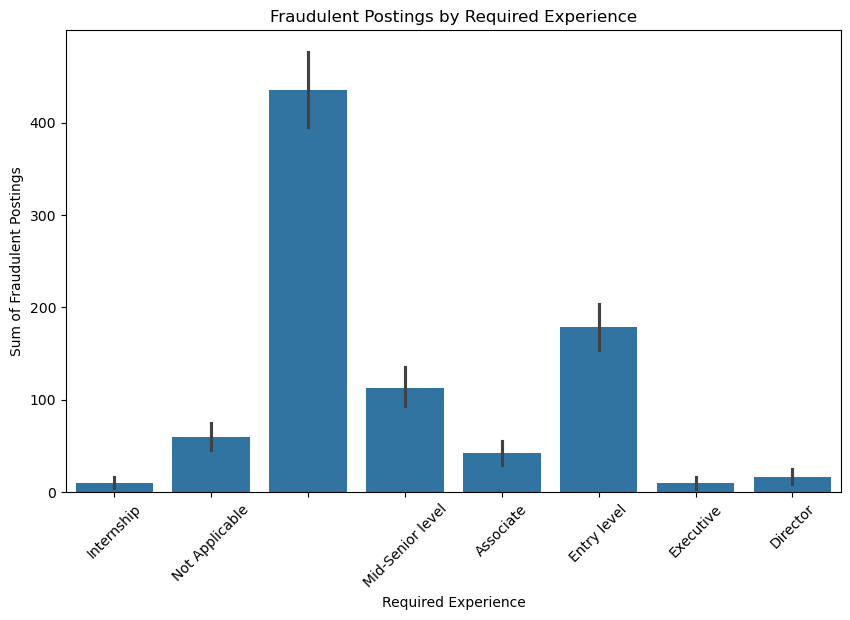

In [14]:
# Visualizing Class Distribution Before Preprocessing
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='required_experience', y='fraudulent', estimator=sum)
plt.title('Fraudulent Postings by Required Experience')
plt.xlabel('Required Experience')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

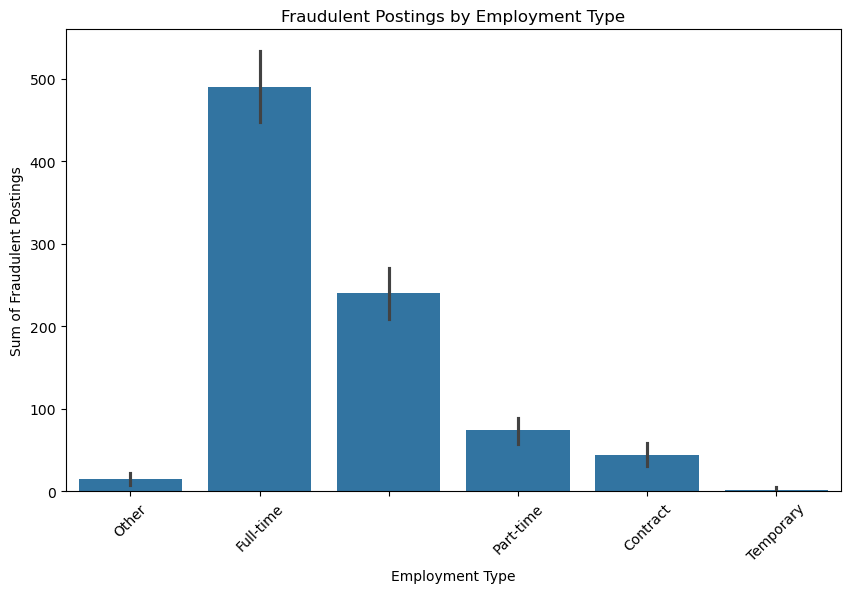

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='employment_type', y='fraudulent', estimator=sum)
plt.title('Fraudulent Postings by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

In [16]:
# Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    return text.strip()

In [17]:
# Apply preprocessing to relevant text columns
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].applymap(preprocess_text)

C:\Users\aderi\AppData\Local\Temp\ipykernel_103728\2664722900.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[text_columns] = df[text_columns].applymap(preprocess_text)


In [18]:
# Combine text features into a single column
df['combined_text'] = df[text_columns].agg(' '.join, axis=1)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.98      0.65      0.78       173

    accuracy                           0.98      3576
   macro avg       0.98      0.82      0.89      3576
weighted avg       0.98      0.98      0.98      3576



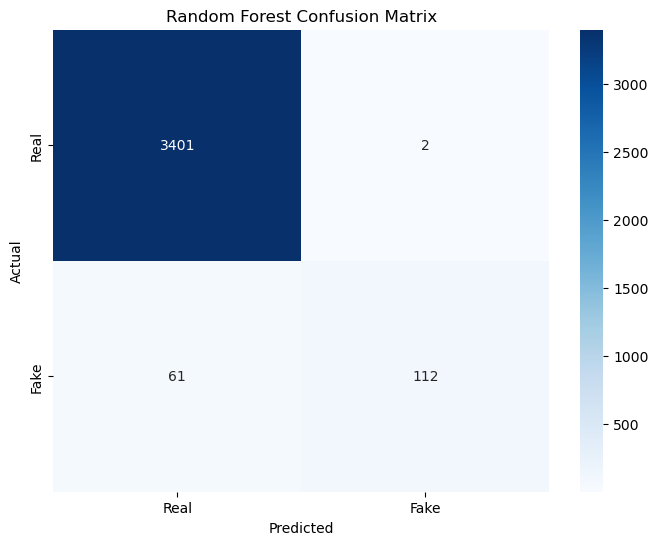

False Positives:
7346    housing counselor  basic job function nbsp  nb...
3839    accounts payable supervisor  the accounts paya...
Name: combined_text, dtype: object
False Negatives:
7830     position finance assistant  we have positions ...
8836     maintenance specialist as the industry s large...
17648    vemma brand partner  looking for motivated and...
17604    subsea installation engineer  job description ...
12104    production manager heavy duty diesel  job titl...
                               ...                        
4650     make easy money at home dmt instant reward  we...
5418     sales associate  sales associates   change you...
17530    casual job immediate start  looking for  work ...
17788    administrative specialist ii  find more jobs a...
11587    seo analysis bright edge and aptitude staffing...
Name: combined_text, Length: 61, dtype: object
Sample False Positives:
 7346    housing counselor  basic job function nbsp  nb...
3839    accounts payable supervisor 

In [19]:
# TF-IDF for Fraudulent Job Posting Classification - Random Forest
# Train-Test Split
X = df['combined_text']
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_tfidf.toarray(), y_train)  # Convert sparse matrix to dense

# Train RandomForest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_smote, y_smote)

# Evaluate Model
y_pred = model.predict(X_test_tfidf)

print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Extract and Analyze False Positives and False Negatives
false_positives = X_test[(y_test == 0) & (y_pred == 1)]
false_negatives = X_test[(y_test == 1) & (y_pred == 0)]

print("False Positives:")
print(false_positives)

print("False Negatives:")
print(false_negatives)

# Sample Review of False Positives and False Negatives
print("Sample False Positives:\n", false_positives.head())
print("Sample False Negatives:\n", false_negatives.head())

# Cross-Validation for Random Forest
cross_val_scores_rf = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("Random Forest Cross-Validation Accuracy Scores:", cross_val_scores_rf)
print("Mean Cross-Validation Accuracy:", cross_val_scores_rf.mean())


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3403
           1       0.70      0.90      0.79       173

    accuracy                           0.98      3576
   macro avg       0.85      0.94      0.89      3576
weighted avg       0.98      0.98      0.98      3576



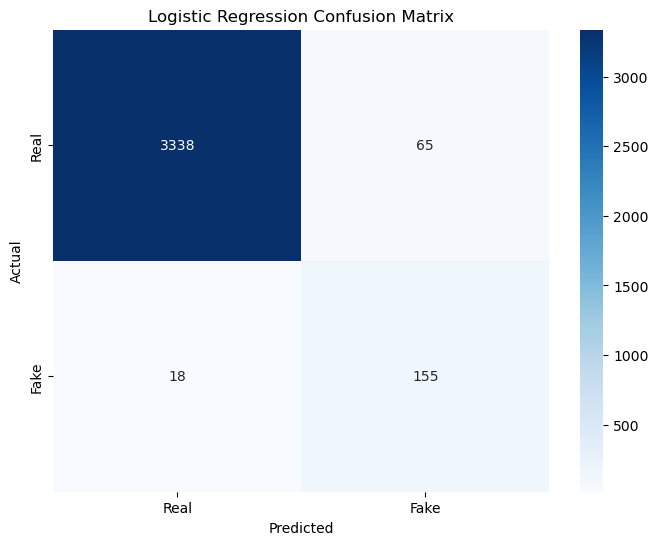

False Positives (Logistic Regression):
3868     director of laboratory services  hospital  hos...
6563     executive assistant  job briefwe are currently...
6585     director of quality lightyear consulting  llc ...
16304    operations support with an exceptional record ...
6674     small engine equipment technician  growing mid...
                               ...                        
16970    customer service   work from home  do you have...
160      field services supervisor dairy  food and beve...
12795    receptionist century  martinez  amp  associate...
10643    reception  foh  our clients are looking for re...
6161     technical support representative  one day hiri...
Name: combined_text, Length: 65, dtype: object
False Negatives (Logistic Regression):
17648    vemma brand partner  looking for motivated and...
17549    sales manager  collaborates with  insert title...
6984     hr process leader  position summary expro s gl...
17598    real estate   insurance professionals el

In [20]:
#logistic regression
#TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_tfidf.toarray(), y_train)  # Convert sparse matrix to dense

# Train Logistic Regression Classifier
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_smote, y_smote)

# Evaluate Model
y_pred_log_reg = log_reg_model.predict(X_test_tfidf)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Extract and Analyze False Positives and False Negatives
false_positives_log_reg = X_test[(y_test == 0) & (y_pred_log_reg == 1)]
false_negatives_log_reg = X_test[(y_test == 1) & (y_pred_log_reg == 0)]

print("False Positives (Logistic Regression):")
print(false_positives_log_reg)

print("False Negatives (Logistic Regression):")
print(false_negatives_log_reg)

# Sample Review of False Positives and False Negatives
print("Sample False Positives (Logistic Regression):\n", false_positives_log_reg.head())
print("Sample False Negatives (Logistic Regression):\n", false_negatives_log_reg.head())

# Cross-Validation for Logistic Regression
cross_val_scores_log_reg = cross_val_score(log_reg_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("Logistic Regression Cross-Validation Accuracy Scores:", cross_val_scores_log_reg)
print("Mean Cross-Validation Accuracy:", cross_val_scores_log_reg.mean())


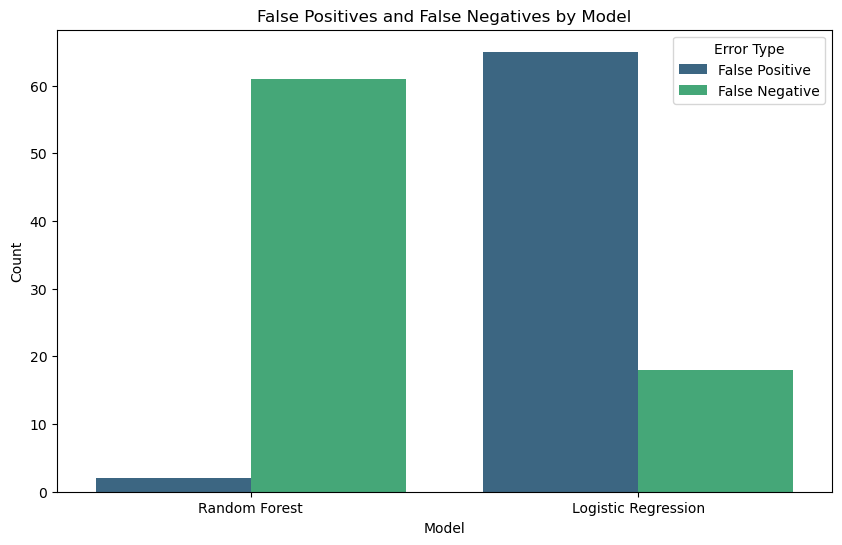

Sample False Positives (Random Forest):
 7346    housing counselor  basic job function nbsp  nb...
3839    accounts payable supervisor  the accounts paya...
Name: combined_text, dtype: object
Sample False Negatives (Random Forest):
 7830     position finance assistant  we have positions ...
8836     maintenance specialist as the industry s large...
17648    vemma brand partner  looking for motivated and...
17604    subsea installation engineer  job description ...
12104    production manager heavy duty diesel  job titl...
Name: combined_text, dtype: object
Sample False Positives (Logistic Regression):
 3868     director of laboratory services  hospital  hos...
6563     executive assistant  job briefwe are currently...
6585     director of quality lightyear consulting  llc ...
16304    operations support with an exceptional record ...
6674     small engine equipment technician  growing mid...
Name: combined_text, dtype: object
Sample False Negatives (Logistic Regression):
 17648    vemm

In [21]:
# Create DataFrames for Visualization
fp_fn_data = pd.DataFrame({
    'Model': ['Random Forest'] * 2 + ['Logistic Regression'] * 2,
    'Error Type': ['False Positive', 'False Negative'] * 2,
    'Count': [len(false_positives), len(false_negatives), len(false_positives_log_reg), len(false_negatives_log_reg)]
})

# Bar Plot Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=fp_fn_data, x='Model', y='Count', hue='Error Type', palette='viridis')
plt.title('False Positives and False Negatives by Model')
plt.ylabel('Count')
plt.xlabel('Model')
plt.show()

# Sample Review of False Positives and False Negatives
print("Sample False Positives (Random Forest):\n", false_positives.head())
print("Sample False Negatives (Random Forest):\n", false_negatives.head())

print("Sample False Positives (Logistic Regression):\n", false_positives_log_reg.head())
print("Sample False Negatives (Logistic Regression):\n", false_negatives_log_reg.head())

In [22]:
# Extract Distinguishing Words for Fraudulent vs. Legitimate Jobs
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
fraud_word_importance = np.mean(X_train_tfidf.toarray()[y_train == 1], axis=0)
legit_word_importance = np.mean(X_train_tfidf.toarray()[y_train == 0], axis=0)

top_fraud_words = feature_names[np.argsort(fraud_word_importance)[-10:]]  # Top words in fraud postings
top_legit_words = feature_names[np.argsort(legit_word_importance)[-10:]]  # Top words in legitimate postings

print("\nTop distinguishing words in **fraudulent** job postings:", top_fraud_words)
print("Top distinguishing words in **legitimate** job postings:", top_legit_words)




Top distinguishing words in **fraudulent** job postings: ['we' 'work' 'you' 'for' 'with' 'in' 'of' 'the' 'to' 'and']
Top distinguishing words in **legitimate** job postings: ['our' 'you' 'for' 'we' 'with' 'in' 'of' 'the' 'to' 'and']


In [23]:
# Word2Vec for Finding Similar Job Descriptions
# Tokenization for Word2Vec
tokenized_corpus = [text.split() for text in df['combined_text']]


In [24]:
# Train Word2Vec Model
word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=2, workers=4)

# Function to compute average Word2Vec embedding
def get_embedding(text, model):
    words = text.split()
    embeddings = [model.wv[word] for word in words if word in model.wv]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(model.vector_size)



In [25]:
# Compute embeddings for all job descriptions
df['embedding'] = df['combined_text'].apply(lambda x: get_embedding(x, word2vec_model))
# Convert embeddings to a numpy array
embedding_matrix = np.vstack(df['embedding'].values)


In [26]:
# Function to find similar job descriptions
def find_similar_jobs(job_text, model, df, top_n=5):
    job_embedding = get_embedding(job_text, model).reshape(1, -1)
    similarities = cosine_similarity(job_embedding, embedding_matrix).flatten()
    similar_indices = similarities.argsort()[-top_n:][::-1]
    return df.iloc[similar_indices][['title', 'company_profile', 'description', 'requirements', 'benefits']]

# Example: Find jobs similar to "Software engineer with Python and ML"
sample_job_analytics = "Data analyst with experience in SQL, Python, and Tableau for business intelligence"
#sample_job = "Software engineer with experience in Python and machine learning"
similar_jobs = find_similar_jobs(sample_job_analytics, word2vec_model, df)
print("\nTop similar job descriptions:\n", similar_jobs)



Top similar job descriptions:
                                                    title  \
6426                                senior quant analyst   
13615                      business intelligence analyst   
13562               project manager conversion migration   
3915   data warehouse manager   business intelligence...   
13589                            senior business analyst   

                                         company_profile  \
6426   formed in   saul amp partners is an executive ...   
13615  maxnet offers staff augmentation solutions for...   
13562  maxnet offers staff augmentation solutions for...   
3915   dawanda is the online marketplace for unique a...   
13589  search  amp  placement for technical and quant...   

                                             description  \
6426   senior quant analystour client is an award win...   
13615  i got this from the hiring manager  would like...   
13562  client is looking for sr  project manager conv...   
3915  

C:\Users\aderi\AppData\Local\Temp\ipykernel_103728\500781368.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=similarity_scores, y=similar_jobs['title'], palette="Blues_r")


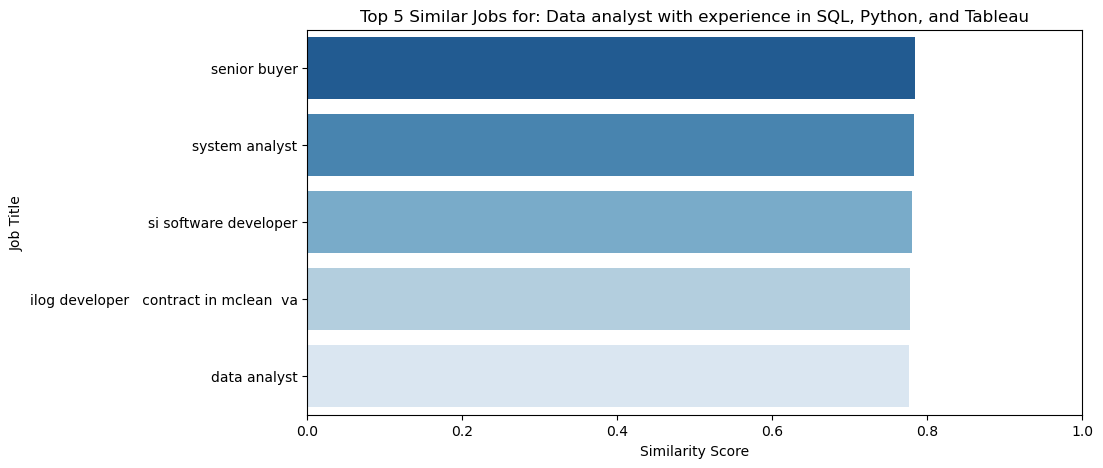

In [27]:
import matplotlib.pyplot as plt

def plot_similarity_scores(job_text, model, df, top_n=5):
    job_embedding = get_embedding(job_text, model).reshape(1, -1)
    similarities = cosine_similarity(job_embedding, embedding_matrix).flatten()
    similar_indices = similarities.argsort()[-top_n:][::-1]

    # Retrieve job titles and similarity scores
    similar_jobs = df.iloc[similar_indices][['title']]
    similarity_scores = similarities[similar_indices]

    # Plot the similarity scores
    plt.figure(figsize=(10, 5))
    sns.barplot(x=similarity_scores, y=similar_jobs['title'], palette="Blues_r")
    plt.xlabel("Similarity Score")
    plt.ylabel("Job Title")
    plt.title(f"Top {top_n} Similar Jobs for: {job_text}")
    plt.xlim(0, 1)  # Cosine similarity scores range from 0 to 1
    plt.show()

# Example Usage: Plot similar jobs for Data Analyst role
plot_similarity_scores("Data analyst with experience in SQL, Python, and Tableau", word2vec_model, df)
